# Index

* [Data Preparation](#data_prepare)
    - [Missing Values](#missing_values)
    - [Feature Engineering](#feat_engineering)
        - [Wind Velocity related features](#wind_feat)
        - [Time related features](#time_feat)
        - [EDA of new features](#new_feat_eda)
        - [Feature Importance](#feat_importance)
        - [Feature transformations](#feat_transformation)
    - [Target transformation](#target_transfomation)
    - [Outliers and abnormal data](#outliers)
    - [Best Numerical Weather Predictor](#bestnwp)

In [1]:
# Libraries

%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np
import datetime as dt
import gc
import missingno as msno
import pandas_profiling
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import random

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as pty
import re

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# Data Preparation
<a id="data_prepare"></a>

We'll create a pipeline with scikit learn to perform the data preparation including the transformations identified in EDA, recall here:
* Input missing values
* Create new features:
    - Wind related features
        - Wind velocity module.
        - Wind direction.
        - Wind velocity escaled to heigth of the turbine. We can calculate it by using the *Hellmann power equation*:
    
            $$u(z) = u(z_0)\left(\frac{z}{z_0}\right)^{\alpha},$$ 
      
          with $\alpha = 1/7$, $z_0 = 100$ or $10$ meters, depending on the NWP data, and $z = 50$ m, the height of the 
          turbines.
          
    - Date time future enconding to capture seasonality:
        - Diurnal variations of average wind speeds (hour feature).
        - Monthly variations of averge wind speeds  (month feature).


* Stardard Scaling of variables
* Temperature `T` in $^\text{o}$C instead of Kelvin
* Outliers and abnormal data:
    - Abnormal data: `CLCT` negative values.
    - Outliers: using power curve as a reference to deal with typical outlier types in this context:
        - Data points in low wind speed period with high power generation.
        - Data points with negtative value wind speed.
        - Data points with negative valu power generation.
        - Data points with low power generation at high wind speed period.
* Feature selection

In [2]:
df_eda = context.catalog.load("df_WF1")

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



2020-10-09 20:59:30,429 - kedro.io.data_catalog - INFO - Loading data from `df_WF1` (CSVDataSet)...


In [3]:
X_train_WF1 = context.catalog.load("X_train_WF1")

2020-10-09 21:01:55,672 - kedro.io.data_catalog - INFO - Loading data from `X_train_WF1` (CSVDataSet)...


In [4]:
y_train_WF1 = context.catalog.load("y_train_WF1")

2020-10-09 21:02:02,130 - kedro.io.data_catalog - INFO - Loading data from `y_train_WF1` (CSVDataSet)...


In [19]:
y_train_WF1.describe()

,0
count,3935.000000
mean,1.723375
std,2.536952
min,0.000000
25%,0.010000
50%,0.400000
75%,2.540000
max,10.130000


## Missing Values
<a id="missing_values"></a>

**Assumption**: Meteorological forecasts accuracy and reliability are the highest for Forecast Day `D` and Run `18h` (the shorter the gap time between NWP Run and the time forecasted, the higher the realiability).


For `X_train`:
We'll use whenever it's possible, data from forecast day `D` and run `18h` for every `NWP` as they're the most recent data available. When there're missing values, we'll use the corresponding data from previous days to fill in the gap, sequencely.

Moreover, `NWP2` and `NWP3` provides data every 3 hours, instead of every 1 hour, as `NWP1` and `NWP4` do. 
* `NWP1`: day 13/07/2018 is fully missing. We'll use `D-1` forecasts to input these values.
* `NWP4`: day 15/05/2018 is fully missing. We'll use `D-1` forecasts to input these values.
* `NWP2` and `NWP3`: we will interpolate these values, missing three hours in between every data.

For `X_test`:
The rules of the challenge point out that we can only use data available on day `D` at 09:00 h (practically that means forecast from day `D-1` and Run 00h). We have then the following missing values to input:

* `NWP1` and `NWP4`: no missing values for the most recent data (forecast day D-1, Run 00h).
* `NWP2` and `NWP3`: we will interpolate these values, missing three hours in between every data 

In [ ]:
# We'll add new columns NWPX_<met_var> without missing values
new_cols = ['NWP1_U', 'NWP1_V', 'NWP1_T', 'NWP2_U', 
            'NWP2_V', 'NWP3_U', 'NWP3_V', 'NWP3_T',
            'NWP4_U', 'NWP4_V', 'NWP4_CLCT']      

In [ ]:
# input missing values in X_train
X_train_cpy = X_train.copy()
cols_train = X_train_cpy.columns[3:] 
new_cols = ['NWP1_U','NWP1_V','NWP1_T',
           'NWP2_U','NWP2_V',
           'NWP3_U','NWP3_V','NWP3_T',
           'NWP4_U','NWP4_V','NWP4_CLCT']

dtr.add_new_cols(new_cols, X_train_cpy)
dtr.input_missing_values(X_train_cpy, cols_train)

col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']
dtr.interpolate_missing_values(X_train_cpy, col_list, 'Time')

Let's check the consistency of the data after the missing values inputation.

In [ ]:
X_train[['NWP4_00h_D_U','NWP4_12h_D_U']].head(30)

In [ ]:
X_train_cpy[new_cols].head(10)

All seems OK for `X_train`.

In [ ]:
# input missing values in X_test
X_test_cpy = X_test.copy()
cols_test = X_test_cpy.columns[3:-9] 

dtr.add_new_cols(new_cols, X_test_cpy)
dtr.input_missing_values(X_test_cpy, cols_test)

col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']
dtr.interpolate_missing_values(X_test_cpy, col_list, 'Time')

In [ ]:
X_test_cpy[new_cols]

All seems OK also for `X_test`

## Feature Engineering
<a id="feat_engineering"></a>

### Wind Velocity related features
<a id="wind_feat"></a>

Adding the following wind velocity derived features for each NWP:
* `NWP<1,2,3,4>_wvel`
* `NWP<1,2,3,4>_wvel`
* `NWP<1,2,3,4>_wshear`
* `NWP<1,2,3,4>_wdir`
* `NWP<1,2,3,4>_wdir_sin`
* `NWP<1,2,3,4>_wdir_cos`

In [ ]:
# Add wind velocity related features in X_train_cpy
regex = r'NWP(?P<NWP>\d{1})_(?P<met_var>[UV])'
dtr.add_wind_vars(X_train_cpy, regex)

In [ ]:
# Add wind velocity related features in X_test_cpy
dtr.add_wind_vars(X_test_cpy, regex)

### Time related features 
<a id="time_feat"></a>

Adding the following date time velocity derived features:
* `hour`
* `month`
* `hour_sin`
* `hour_cos`

In [ ]:
# Add time related features in X_train_cpy
dtr.add_time_vars(X_train_cpy, 'Time')

In [ ]:
# Add time related features in X_test_cpy
dtr.add_time_vars(X_test_cpy, 'Time')

### EDA of new features
<a id="new_feat_eda"></a>

Let's come back to EDA now to visualize the distributions, dependencies and behaviour of the new added features.

#### Wind velocity distributions

In [ ]:
import plotly.figure_factory as ff

# Group data together
hist_data = [df_eda['NWP1_wvel'],df_eda['NWP2_wvel'],df_eda['NWP3_wvel'],df_eda['NWP4_wvel']]
group_labels = ['NWP1 wind vel', 'NWP2 wind vel', 'NWP3 wind vel', 'NWP4 wind vel']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
fig.show()

#### Time dependency

In [ ]:
# Time series visualization
df_eda['NWP3_T_cels'] = df_eda['NWP3_T'] - 273
df_eda[
    ['Time','NWP1_wvel','NWP1_wdir', 'NWP3_T_cels']].set_index('Time').iplot(
    kind='scatter', 
    filename='cufflinks/cf-simple-line'
)

In [ ]:
df_eda.loc[df_eda['NWP3_wvel'] == max(df_eda['NWP3_wvel'])]

In [ ]:
df_eda.loc[df_eda['NWP3_wvel'] == min(df_eda['NWP3_wvel'])]

#### Dependency between wind power and wind velocity

In [ ]:
fig = make_subplots(rows=2, 
                    cols=2, 
                    start_cell="top-left",
                    x_title='wind velocity [m/s]',
                    y_title='wind power [MWh]')

fig.add_trace(go.Scatter(x=df_eda['NWP1_wvel'], y=df_eda['Production'], mode="markers", marker=dict(size=3), name='NWP1'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_eda['NWP2_wvel'], y=df_eda['Production'], mode="markers", marker=dict(size=3), name='NWP2'),
              row=1, col=2)

fig.add_trace(go.Scatter(x=df_eda['NWP3_wvel'], y=df_eda['Production'], mode="markers", marker=dict(size=3), name='NWP3'),
              row=2, col=1)

fig.add_trace(go.Scatter(x=df_eda['NWP4_wvel'], y=df_eda['Production'], mode="markers", marker=dict(size=3),  name='NWP4'),
              row=2, col=2)

fig.update_layout(height=800, width=800)

fig.show()

#### Wind direction distribution

In [ ]:
import windrose
import matplotlib.cm as cm

fig = plt.figure()

ax = fig.add_subplot(111, projection="windrose")
ax.bar(df_eda['NWP1_wdir'], df_eda['NWP1_wvel'], normed=True, opening=0.8, edgecolor='white')
# ax.set_legend()

plt.show()

In [ ]:
fig = make_subplots(rows=1, 
                    cols=1, 
                    start_cell="top-left",
                    x_title='wind direction',
                    y_title='wind power production [MWh]')

fig.add_trace(go.Scatter(x=df_eda['NWP1_wdir'], y=df_eda['Production'], mode="markers", marker=dict(size=3), name='NWP1'),
              row=1, col=1)


#### Wind velocity and direction versus power production

In [ ]:
import plotly.express as px

fig = go.Figure(data=[go.Scatter3d(
    x=df_eda['NWP1_wvel'],
    y=df_eda['NWP1_wdir'],
    z=df_eda['Production'],
    mode='markers',
    marker=dict(
        size=3,
        color=df_eda['Production'],            
        colorscale='Viridis', 
        opacity=0.8
    )
)])

fig.update_layout(autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

#### Visualization of dependencies between wind power and meteorological variables (T and CLCT)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, 
                    cols=2, 
                    start_cell="top-left",
                    x_title='air temperature [K]',
                    y_title='power production [MWh]')

fig.add_trace(go.Scatter(x=df_eda['NWP1_T'], y=df_eda['Production'], mode="markers", marker=dict(size=3), name='NWP1'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_eda['NWP3_T'], y=df_eda['Production'], mode="markers", marker=dict(size=3), name='NWP3'),
              row=1, col=2)

fig.update_layout(height=500, width=800)

fig.show()
                

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, 
                    cols=1, 
                    start_cell="top-left",
                    x_title='taotal cloud cover [%]',
                    y_title='power production[MWh]')

fig.add_trace(go.Scatter(x=df_eda['NWP4_CLCT'], 
                         y=df_eda['Production'], 
                         mode="markers", marker=dict(size=3), name='NWP4'),
              row=1, col=1)


fig.update_layout(height=500, width=800)

fig.show()

#### Correlation matrix

In [ ]:
# Looking at correlations
df_eda[['Production','NWP1_U', 'NWP1_V','NWP1_wvel','NWP1_wshear',
        'NWP1_T','NWP1_wdir','NWP1_wdir_sin','NWP1_wdir_cos','month',
       'month_sin','month_cos', 'hour','hour_sin','hour_cos']].corr().iplot(
    kind='heatmap', 
    colorscale='spectral', 
    filename='cufflinks/simple-heatmap'
)

### Feature importance
<a id="feat_importance"></a>

Random Forest can be used to get the importance of the features in a dataset. We will drop all original features that are redudant with dervied ones (high correlated), for example, wind velocity, U and V if wind shear is included.

In [ ]:
## Feature importance for NWP1

from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split

# data
X = X_train_cpy[['NWP1_T',
                'NWP1_wshear','NWP1_wdir_cos','NWP1_wdir_sin',
                'hour_cos','hour_sin',
                'month_sin','month_cos']]
Y = y_train['Production']

# split into train and test sets
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.20, random_state=0)

# instanciate object RandomForestRegressor
model_RFR_NWP1 = RandomForestRegressor()

# fit the model
model_RFR_NWP1.fit(train_x, train_y)

# plot feature importance
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFR_NWP1.feature_importances_, index = train_x.columns)
feat_importances.nlargest(50).plot(kind='barh')

In [ ]:
## Feature importance for NWP2

# data
X2 = X_train_cpy[['NWP2_wshear','NWP2_wdir_cos','NWP2_wdir_sin',
                'hour_cos','hour_sin',
                'month_sin','month_cos']]
Y2 = y_train['Production']

# split into train and test sets
train_x2, test_x2, train_y2, test_y2 = train_test_split(X2, Y2, test_size=0.20, random_state=0)

# instanciate object RandomForestRegressor
model_RFR_NWP2 = RandomForestRegressor()

# fit the model
model_RFR_NWP2.fit(train_x2, train_y2)

# plot feature importance
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFR_NWP2.feature_importances_, index = train_x2.columns)
feat_importances.nlargest(50).plot(kind='barh')

In [ ]:
## Feature importance for NWP3

# data
X3 = X_train_cpy[['NWP3_wshear','NWP3_wdir_cos','NWP3_wdir_sin',
                'hour_cos','hour_sin','month_sin','month_cos']]
Y3 = y_train['Production']

# split into train and test sets
train_x3, test_x3, train_y3, test_y3 = train_test_split(X3, Y3, test_size=0.20, random_state=0)

# instanciate object RandomForestRegressor
model_RFR_NWP3 = RandomForestRegressor()

# fit the model
model_RFR_NWP3.fit(train_x3, train_y3)

# plot feature importance
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFR_NWP3.feature_importances_, index = train_x3.columns)
feat_importances.nlargest(50).plot(kind='barh')

In [ ]:
X_train_cpy.head()

In [ ]:
## Feature importance for NWP4

# data
X4 = X_train_cpy[['NWP4_CLCT','NWP4_wshear','NWP4_wdir_cos','NWP4_wdir','NWP4_wdir_sin', 'hour','month',
                'hour_cos','hour_sin','month_sin','month_cos']]
Y4 = y_train['Production']

# split into train and test sets
train_x4, test_x4, train_y4, test_y4 = train_test_split(X4, Y4, test_size=0.20, random_state=0)

# instanciate object RandomForestRegressor
model_RFR_NWP4 = RandomForestRegressor()

# fit the model
model_RFR_NWP4.fit(train_x4, train_y4)

# plot feature importance
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFR_NWP4.feature_importances_, index = train_x4.columns)
feat_importances.nlargest(50).plot(kind='barh')

#### Visualization  of the sub-feature space selected 

In [ ]:
sns.pairplot(
    df_eda,
    vars = ['NWP1_wshear', 'NWP1_T',
           'NWP1_wdir_sin', 'NWP1_wdir_cos',
           'hour_sin','hour_cos',
           'month_sin','month_cos',
           'Production'],
    diag_kind='kde'
)

### Feature transformations
<a id="feat_transformation"></a>

#### Temperature convertion to $^{\text{o}}$C

In [44]:
X_WF1 = context.catalog.load("X_train_expanded_WF1")
X_WF1['production'] = y_train_WF1[0]

2020-10-08 18:02:56,794 - kedro.io.data_catalog - INFO - Loading data from `X_train_expanded_WF1` (PickleDataSet)...


In [47]:
del X_WF1['Time']

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [48]:
del X_WF1['ID']

In [56]:
corr = X_WF1.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,U,V,T,CLCT,wspeed,wdir,hour,month,hour_sin,hour_cos,month_sin,month_cos,wdir_sin,wdir_cos,wspeed_T,wspeed_wdirsin,wspeed_wdircos,wspeed_wdirsin_T,wspeed_wdircos_T,production
U,1.000000,-0.499959,0.093725,-0.228826,0.161409,0.636242,0.126688,-0.246463,-0.154776,-0.040398,0.037303,-0.314854,-0.824144,0.330295,0.165342,-1.000000,0.499959,-0.999791,0.498260,0.038771
V,-0.499959,1.000000,0.235113,0.131258,-0.415488,-0.491604,0.154759,0.010461,-0.221488,-0.172218,0.073361,0.028729,0.253424,-0.851068,-0.412679,0.499959,-1.000000,0.496462,-0.999857,-0.313315
T,0.093725,0.235113,1.000000,-0.356523,-0.285795,-0.020203,0.175492,-0.133516,-0.224624,-0.232222,-0.267675,-0.384112,-0.162532,-0.242899,-0.259061,-0.093725,-0.235113,-0.104739,-0.230544,-0.304031
CLCT,-0.228826,0.131258,-0.356523,1.000000,0.035081,-0.193472,-0.011256,0.035389,0.025334,0.028760,0.167472,0.160330,0.228173,-0.059153,0.025096,0.228826,-0.131258,0.233003,-0.132493,0.075727
wspeed,0.161409,-0.415488,-0.285795,0.035081,1.000000,0.367461,0.033449,0.169772,-0.055585,-0.002753,-0.039219,0.196896,-0.074225,0.265006,0.999496,-0.161409,0.415488,-0.160460,0.414717,0.899175
wdir,0.636242,-0.491604,-0.020203,-0.193472,0.367461,1.000000,0.093103,-0.087713,-0.082734,-0.018590,-0.022020,-0.137228,-0.692164,0.355368,0.369738,-0.636242,0.491604,-0.636557,0.491697,0.281222
hour,0.126688,0.154759,0.175492,-0.011256,0.033449,0.093103,1.000000,0.012206,-0.775160,-0.097890,-0.001260,0.014505,-0.210091,-0.228254,0.038619,-0.126688,-0.154759,-0.129589,-0.154932,0.039108
month,-0.246463,0.010461,-0.133516,0.035389,0.169772,-0.087713,0.012206,1.000000,-0.011519,-0.002368,-0.828935,0.931013,0.168585,0.074501,0.165226,0.246463,-0.010461,0.244530,-0.010362,0.197867
hour_sin,-0.154776,-0.221488,-0.224624,0.025334,-0.055585,-0.082734,-0.775160,-0.011519,1.000000,-0.010419,0.002095,-0.014169,0.249886,0.315537,-0.062848,0.154776,0.221488,0.158792,0.222098,-0.049239
hour_cos,-0.040398,-0.172218,-0.232222,0.028760,-0.002753,-0.018590,-0.097890,-0.002368,-0.010419,1.000000,0.010635,0.002136,0.079044,0.190215,-0.008724,0.040398,0.172218,0.042467,0.173455,0.002912


In [ ]:
temps = ['NWP1_T', 'NWP3_T']

dtr.convert_to_celsius(X_train_cpy, temps)
dtr.convert_to_celsius(X_test_cpy, temps)

#### Power  tranformations (Box-Cox and Yeo-Johnson)

Some of the features, like wind speed, have skewed distributions. Box-Cox and Yeo-Johnson transformations can be used to get a more Gaussian like distribution. The Box-Cox family transformation is as follows:

$$ \begin{split}x_i^{(\lambda)} =
\begin{cases}
\dfrac{x_i^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0, \\[8pt]
\ln{(x_i)} & \text{if } \lambda = 0,
\end{cases}\end{split} $$

where $\lambda$ can be estimated from the traning data. This transformations can only be applied on positive data. 

Yeo-Johnson transformations can be applied on positive and negative data, given by:

$$
\begin{split}x_i^{(\lambda)} =
\begin{cases}
 [(x_i + 1)^\lambda - 1] / \lambda & \text{if } \lambda \neq 0, x_i \geq 0, \\[8pt]
\ln{(x_i + 1)} & \text{if } \lambda = 0, x_i \geq 0 \\[8pt]
-[(-x_i + 1)^{2 - \lambda} - 1] / (2 - \lambda) & \text{if } \lambda \neq 2, x_i < 0, \\[8pt]
 - \ln (- x_i + 1) & \text{if } \lambda = 2, x_i < 0
\end{cases}\end{split}
$$

We'll try such transformations on our training data set, concretely Yeo-Johnson as we have some predictors with negative values.

In [32]:
featnames = context.catalog.load("feature_names_WF1")
featnames

2020-10-08 17:29:13,178 - kedro.io.data_catalog - INFO - Loading data from `feature_names_WF1` (PickleDataSet)...


Index(['T', 'CLCT', 'wspeed', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'wdir_sin', 'wdir_cos', 'wspeed_T', 'wspeed_wdirsin', 'wspeed_wdircos',
       'wspeed_wdirsin_T', 'wspeed_wdircos_T'],
      dtype='object')

In [35]:
X_train_pped_WF1 = context.catalog.load("X_train_pped_WF1")
df_WF1 = pd.DataFrame(data=X_train_pped_WF1, columns=featnames)

2020-10-08 17:31:00,083 - kedro.io.data_catalog - INFO - Loading data from `X_train_pped_WF1` (PickleDataSet)...


In [38]:
df_WF1['production'] = y_train_WF1[0]

In [39]:
df_WF1.head()

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,T,CLCT,wspeed,hour_sin,hour_cos,month_sin,month_cos,wdir_sin,wdir_cos,wspeed_T,wspeed_wdirsin,wspeed_wdircos,wspeed_wdirsin_T,wspeed_wdircos_T,production
0,-1.755871,0.984558,-0.319161,0.342582,1.367110,1.571999,-0.810147,-0.836230,0.833991,-0.361302,-0.403312,0.362536,-0.394163,0.346239,0.02
1,-1.755871,1.098016,-0.763964,0.687613,1.227471,1.571999,-0.810147,-1.358874,0.400670,-0.790423,-0.403312,0.075602,-0.394163,0.078903,0.07
2,-1.755871,1.088241,-0.370671,0.985281,1.005099,1.571999,-0.810147,-0.884381,0.804571,-0.410997,-0.403312,0.331915,-0.394163,0.317334,0.22
3,-1.812418,1.066625,0.451913,1.214454,0.714812,1.571999,-0.810147,-0.498337,1.001712,0.388750,-0.573222,0.809470,-0.559096,0.775012,0.39
4,-1.868535,1.073142,0.364305,1.358830,0.375978,1.571999,-0.810147,-0.717795,0.900105,0.300440,-0.745495,0.694674,-0.724262,0.662552,0.41


In [ ]:
pt.pyplot()

In [ ]:
from sklearn.preprocessing import PowerTransformer

# Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=True)
x_trnsf = pt.fit_transform(df_eda[['NWP1_wshear', 'NWP1_T',
           'NWP1_wdir_sin', 'NWP1_wdir_cos',
           'hour_sin','hour_cos',
           'month_sin','month_cos']])

x_trnsf_df = pd.DataFrame(data=x_trnsf)

In [ ]:
sns.pairplot(
    x_trnsf_df,
    diag_kind='kde'
)

In [ ]:
pt.lambdas_

In [ ]:
pt = PowerTransformer(method='box-cox', standardize=True)
x_trnsf = pt.fit_transform(df_eda[['NWP1_wshear', 'NWP1_T']])
x_trnsf_df = pd.DataFrame(data=x_trnsf)
sns.pairplot(x_trnsf_df,diag_kind='kde')

In [ ]:
pt.lambdas_

In [ ]:
# standard scaler
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
x_trnsf = ss.fit_transform(df_eda[['NWP1_wshear', 'NWP1_T']])
x_trnsf_df = pd.DataFrame(data=x_trnsf)
sns.pairplot(x_trnsf_df,diag_kind='kde')

In [ ]:
# MinMax transformation
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()
x_trnsf = mm.fit_transform(df_eda[['NWP1_wshear', 'NWP1_T',
           'NWP1_wdir_sin', 'NWP1_wdir_cos',
           'hour_sin','hour_cos',
           'month_sin','month_cos']])

x_trnsf_df = pd.DataFrame(data=x_trnsf)
sns.pairplot(x_trnsf_df,diag_kind='kde')

## Target transfomation
<a id="target_transformation"></a>

The target (power production by the WF) has a very right skewed distribution also:

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<AxesSubplot:ylabel='Density'>

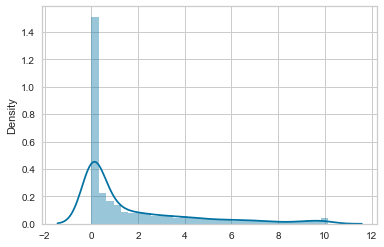

In [20]:
sns.distplot(y_train_WF1, kde=True)

<AxesSubplot:ylabel='Density'>

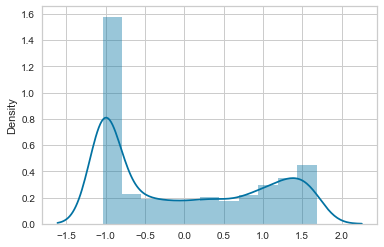

In [23]:
mm = PowerTransformer(method='yeo-johnson', standardize=True)
y_trnsf = mm.fit_transform(np.array(y_train_WF1).reshape(-1,1))

sns.distplot(y_trnsf, kde=True)

We may also use a power transformation to handle the skeweness of the target distribution (more appropriate in this case than the log transformation, as the target has many 0 values).

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<AxesSubplot:ylabel='Density'>

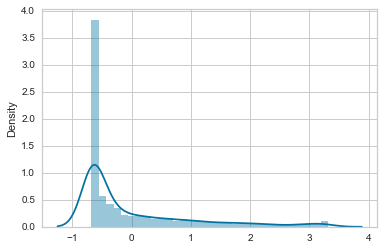

In [28]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
y_trnsf = StandardScaler().fit_transform(np.array(y_train_WF1).reshape(-1,1))

sns.distplot(y_trnsf, kde=True)

## Outliers and abnormal data
<a id="outliers"></a>

In weather parameters (except `CLCT`) there's no abnormal data, as we saw in notebook `1.1-vcp-explore-data`. We need to focus on the following four types of outliers:
1. Data points in low wind speed period with high power generation.
2. Data points with negtative value wind speed.
3. Data points with negative value power generation.
4. Data points with low power generation at high wind speed period.

Let's have a quick look at the data sets to check types 2 and 3:

In [ ]:
pd.options.display.max_columns = None
df_eda[df_eda.columns[-38:]].describe()

There isn't any type 2 neither 3 outliers. However, looking at `CLCT`, which represents the cloud coverage percentage, we see the minimum value is negative, which makes nonsense. 

In [ ]:
for val in df_eda['NWP4_CLCT'].sort_values(ascending=True):
    print(val)

Negative values are very close to 0, it makes sense to replace all these observations by 0.

In [ ]:
X_train_cpy.loc[X_train_cpy['NWP4_CLCT'] < 0, 'NWP4_CLCT'] = 0.0
X_test_cpy.loc[X_test_cpy['NWP4_CLCT'] < 0, 'NWP4_CLCT'] = 0.0

In [ ]:
X_train_cpy['NWP4_CLCT'].sort_values(ascending=True)

#### Trying some ML algorithms to detect outliers

In [ ]:
# Import models
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM

from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

df = df_eda[['NWP1_wvel','Production']]

mm = PowerTransformer(method='yeo-johnson', standardize=True)

X1 = mm.fit_transform(np.array(df['NWP1_wvel']).reshape(-1,1))
X2 = mm.fit_transform(np.array(df_eda['Production']).reshape(-1,1))

#X1 = df['NWP1_wvel'].values.reshape(-1,1)
#X2 = df['Production'].values.reshape(-1,1)
X = np.concatenate((X1,X2), axis=1)

random_state = np.random.RandomState(42)
outliers_fraction = 0.10

# Define seven outlier detection tools to be compared
classifiers = {
        'One-class SVM detector (OCSVM)': OCSVM(contamination=outliers_fraction), 
        #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        #'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state, n_estimators=10000),
        #'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction, radius=0.05),
        #'Average KNN': KNN(method='mean',contamination=outliers_fraction, n_neighbors=9)
}


In [ ]:
xx , yy = np.meshgrid(np.linspace(0, 30 , 200), np.linspace(0, 12, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['NWP1_wvel'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['Production'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['NWP1_wvel'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['Production'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 30))
    plt.ylim((0, 12))
    plt.title(clf_name)
    plt.show()

In [ ]:
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

# copy of dataframe
dfx = df
dfx['outlier'] = y_pred.tolist()

In [ ]:
X1 = np.array(df['NWP1_wvel']).reshape(-1,1)
X2 = np.array(df_eda['Production']).reshape(-1,1)
X = np.concatenate((X1,X2), axis=1)

In [ ]:
X.shape

In [ ]:
import hdbscan

mm = StandardScaler()

X1 = mm.fit_transform(np.array(df['NWP1_wvel']).reshape(-1,1))
X2 = mm.fit_transform(np.array(df_eda['Production']).reshape(-1,1))
X = mm.fit_transform(np.concatenate((X1,X2), axis=1))

clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=25).fit(X)

In [ ]:
clusterer

In [ ]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.96)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*X.T, s=50, linewidth=0, c='gray', alpha=0.20)
plt.scatter(*X[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)

In [ ]:
outliers

In [ ]:
color_palette = sns.color_palette()
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*X.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [ ]:
clusterer.labels_.shape

In [ ]:
## With DBSCAN 
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
    eps = 0.1,
    metric="l1",
    min_samples = 10,
    n_jobs = -1)


mm = PowerTransformer(method='yeo-johnson', standardize=True)

X1 = mm.fit_transform(np.array(df['NWP1_wvel']).reshape(-1,1))
X2 = mm.fit_transform(np.array(df_eda['Production']).reshape(-1,1))
X = np.concatenate((X1,X2), axis=1)

clusters = outlier_detection.fit_predict(X)

In [ ]:
outliers = np.where(clusters == -1)[0]

In [ ]:
plt.scatter(*X.T, s=50, linewidth=0, c='gray', alpha=0.20)
plt.scatter(*X[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)

In [ ]:
df.shape

In [ ]:
%store X_train_cpy
%store X_test_cpy
%store y_train
%store y_test

In [ ]:
X_test.head()